# 悉尼天气预测

通过对悉尼当天的各种气象因素（湿度，压力，风向等）对第二天是否下雨，降水量多少进行预测。

数据集来源：https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## 导入所需库

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = None
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest,f_regression,f_classif,chi2
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 数据清理

读取数据集，检查数据类型以及缺失值数量。这里只读取悉尼天气数据，因此筛选掉其他城市的气象数据。

In [2]:
weather=pd.read_csv('weatheraus.csv')
weather_sydney=weather[weather['Location']=='Sydney']

In [3]:
weather_sydney.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
29497,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,6.0,Yes
29498,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,6.6,Yes
29499,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,18.8,Yes
29500,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,77.4,Yes
29501,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,1.6,Yes


In [4]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3331 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3331 non-null object
RISK_MM          3337 non-null float

In [5]:
weather_sydney.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,3334.000000,3335.000000,3331.000000,3286.000000,3321.000000,2301.000000,3311.000000,3312.000000,3323.000000,3324.000000,3317.000000,3318.000000,2771.000000,2776.000000,3333.000000,3333.000000,3337.000000
mean,14.865057,23.002339,3.330231,5.187432,7.179374,41.761408,15.070674,19.335447,68.229010,54.699158,1018.346156,1016.018774,4.181523,4.218660,17.819742,21.533333,3.319868
std,4.553641,4.494638,9.895172,2.777407,3.810886,13.007523,7.079724,7.482554,15.085355,16.293530,7.021571,7.032211,2.749578,2.641885,4.897177,4.303737,9.885066
min,4.300000,11.700000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,19.000000,10.000000,986.700000,989.800000,0.000000,0.000000,6.400000,10.200000,0.000000
25%,11.000000,19.600000,0.000000,3.200000,4.300000,31.000000,9.000000,15.000000,58.000000,44.000000,1013.700000,1011.300000,1.000000,1.000000,13.800000,18.400000,0.000000
50%,14.900000,22.800000,0.000000,4.800000,8.300000,41.000000,15.000000,19.000000,69.000000,56.000000,1018.600000,1016.300000,5.000000,4.000000,18.200000,21.300000,0.000000
75%,18.700000,26.000000,1.400000,7.000000,10.200000,50.000000,20.000000,24.000000,80.000000,65.000000,1023.100000,1020.800000,7.000000,7.000000,21.700000,24.500000,1.400000
max,27.600000,45.800000,119.400000,18.400000,13.600000,96.000000,54.000000,57.000000,100.000000,99.000000,1039.000000,1036.700000,9.000000,8.000000,36.500000,44.700000,119.400000


从info()中可看出缺失值主要存在于每日最强风的风力与风速，以及云层厚度。接下来检查数据集中是否有重复数据，例如同一天的气象数据出现了多次。

In [6]:
weather_sydney=weather_sydney.drop_duplicates(subset='Date', keep='first', inplace=False)
weather_sydney.shape[0]

3337

数据集依旧是3337行，所以数据集中并没有重复日期。

预测变量‘RainToday’（今日是否下雨），‘Rainfall’（今日降水量）中各有6个缺失值，但是此变量值可由上一天的‘RainTomorrow’（明日是否下雨）及‘RISK_MM’（明日降水量）推测出，所以‘RainToday’与‘Rainfall’的缺失值可以用此法填补。

In [7]:
for index in weather_sydney.index:
    if pd.isnull(weather_sydney.loc[index,'RainToday']):
        weather_sydney.loc[index,['RainToday']]=weather_sydney.loc[index-1,['RainTomorrow']][0]
    if pd.isnull(weather_sydney.loc[index,'Rainfall']):
        weather_sydney.loc[index,['Rainfall']]=weather_sydney.loc[index-1,['RISK_MM']][0]

对于其余的缺失值我们选择将其所在行删除，最后剩余1692行数据。之后剔除不需要的列‘Date’，‘Location’，‘RainToday’，‘RainTomorrow’。

In [8]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3337 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3337 non-null object
RISK_MM          3337 non-null float

In [9]:
weather_sydney=weather_sydney.dropna()
weather_sydney=weather_sydney.drop(columns=['Date','Location'])

对于类别变量，我们将‘Yes’和‘No’统一转化为1和0，并将风向变量向量化，即独热编码。

In [10]:
weather_sydney2=weather_sydney

In [11]:
weather_sydney=weather_sydney.replace('Yes',1)
weather_sydney=weather_sydney.replace('No',0)
weather_sydney= pd.get_dummies(weather_sydney,columns = ['WindGustDir','WindDir9am','WindDir3pm'],drop_first=True)

## 基础分析

首先分析风向因素，这里选取第二天会下雨的数据（RainTomorrow=Yes），统计下雨前一天的风向分布。

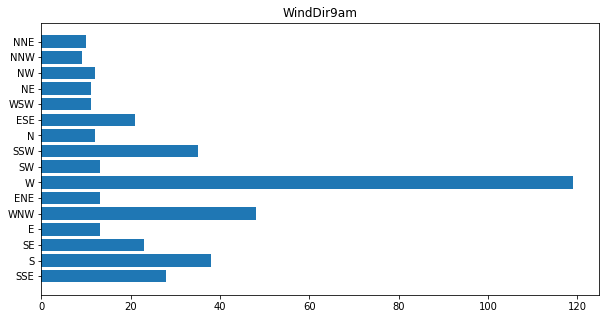

In [12]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir9am'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir9am')
plt.show()

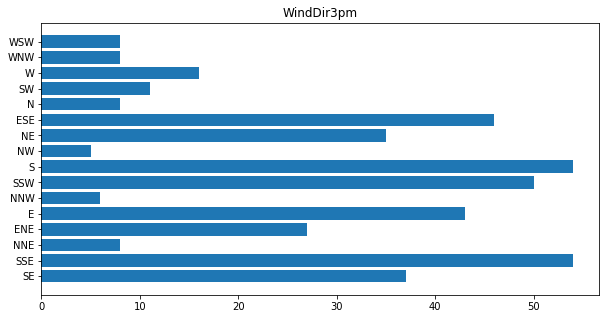

In [13]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir3pm'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir3pm')
plt.show()

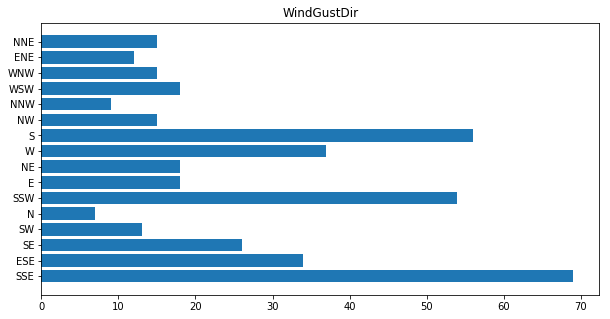

In [14]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindGustDir'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindGustDir')
plt.show()

可看出，如果上午9点风向为西风，下午3点风向大致为南风或东风，当日最大风为偏西南风时，第二天下雨情况居多。悉尼地处澳大利亚东南部，除了上午9点是情况，其他情况皆符合常理。

接下来分析云层厚度与降水的关系。

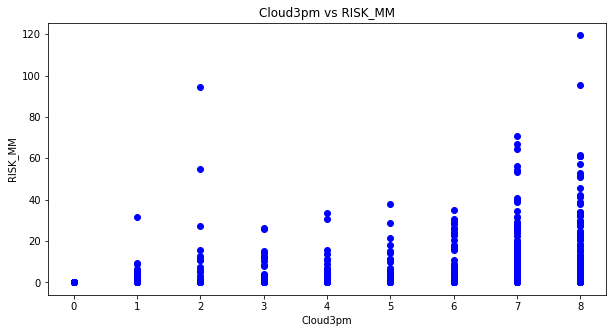

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Cloud3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Cloud3pm vs RISK_MM')
plt.xlabel('Cloud3pm')
plt.ylabel('RISK_MM')
plt.show()

除了个别极端情况，总体上看随着云层厚度增加，第二天降水量有上升趋势。

湿度与降水也可观察到正相关关系。

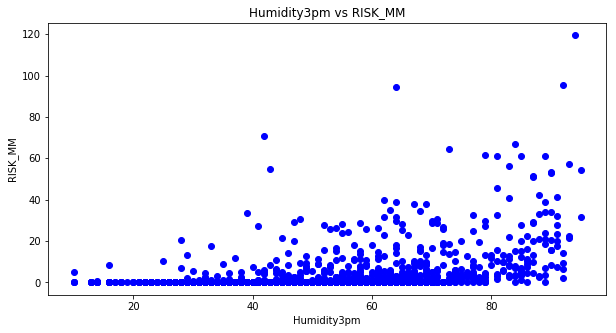

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Humidity3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Humidity3pm vs RISK_MM')
plt.xlabel('Humidity3pm')
plt.ylabel('RISK_MM')
plt.show()

今天的降水量之间是否对明天的降水量有影响？由散点图看是呈负相关。

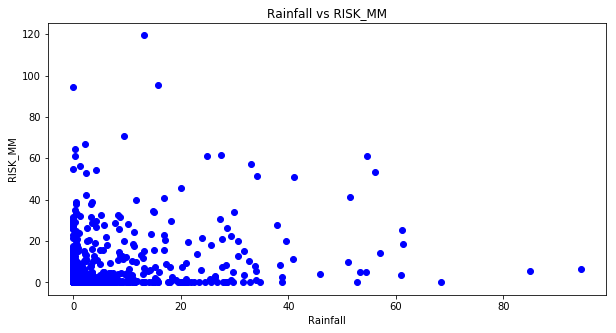

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Rainfall'],weather_sydney2['RISK_MM'],color='b')
plt.title('Rainfall vs RISK_MM')
plt.xlabel('Rainfall')
plt.ylabel('RISK_MM')
plt.show()

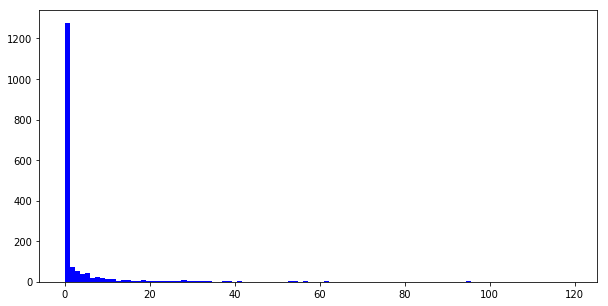

In [18]:
plt.figure(figsize=(10,5))
plt.hist(weather_sydney2['RISK_MM'],color='b',bins=100)

plt.show()

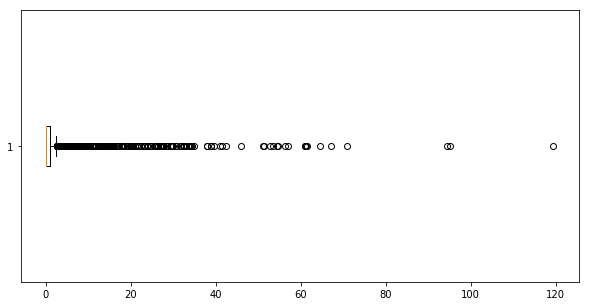

In [19]:
plt.figure(figsize=(10,5))
plt.boxplot(weather_sydney2['RISK_MM'],vert=False)
plt.show()

降水量似乎呈泊松分布，应考虑适不适合使用回归模型预测降水量。

## 建模

### 线性回归（PCA）

查看变量间相关系数

In [38]:
y=weather_sydney['RISK_MM']
X0=weather_sydney2[weather_sydney2.columns.difference(['RainToday','RainTomorrow','RISK_MM','WindDir3pm','WindDir9am','WindGustDir','WindGustSpeed' ,'WindSpeed3pm' ,'WindSpeed9am'])]

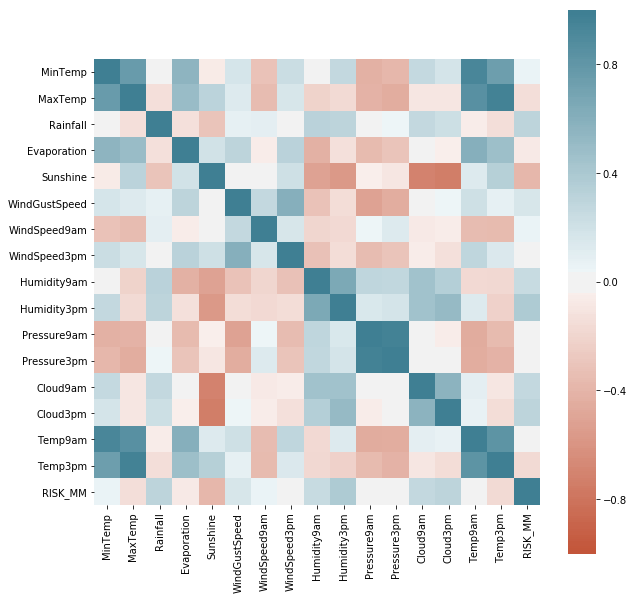

In [35]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(weather_sydney2.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
plt.show()
 

In [40]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X0, y,
                                                    test_size=0.30,
                                                   )
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


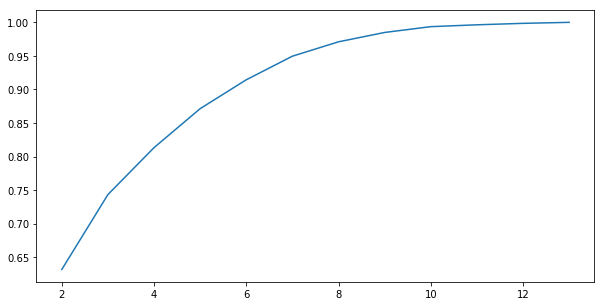

In [43]:

from sklearn.decomposition import PCA
ratio=[]
for n in [2,3,4,5,6,7,8,9,10,11,12,13]:
    pca=PCA(n_components=n)
    pca.fit(X_train)  
    ratio.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize=(10,5))
plt.plot([2,3,4,5,6,7,8,9,10,11,12,13],ratio)
plt.show()

设置阈值为0.9，则由图知特征数取6。

In [47]:
from sklearn.pipeline import make_pipeline

std_clf = make_pipeline(PCA(n_components=6), LinearRegression())
std_clf.fit(X_train, y_train)
y_pred= std_clf.predict(X_test)

In [49]:
r2_score( y_test, y_pred)

0.21480647916275664

### 线性回归（特征选择）

挑选其中对因变量影响最大的20个自变量

In [62]:
y=weather_sydney['RISK_MM']
X1=weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]
best=SelectKBest(f_regression, k=10)
best.fit(X1,y)

SelectKBest(k=10, score_func=<function f_regression at 0x000002CBDADE1598>)

In [63]:
pd.DataFrame(data={'feature':X1.columns,'score':best.scores_}).sort_values(by=['score'],ascending=0)

,feature,score
3,Humidity3pm,294.698309
10,Sunshine,285.637046
0,Cloud3pm,175.451614
9,Rainfall,166.525322
1,Cloud9am,134.489998
4,Humidity9am,118.191044
11,Temp3pm,50.606492
58,WindGustSpeed,50.494545
5,MaxTemp,37.570661
35,WindDir9am_S,33.255359


In [64]:
columns=list(pd.DataFrame(data={'feature':X1.columns,'score':best.scores_}).sort_values(by=['score'],ascending=0)['feature'][0:20])
print(columns)

['Humidity3pm', 'Sunshine', 'Cloud3pm', 'Rainfall', 'Cloud9am', 'Humidity9am', 'Temp3pm', 'WindGustSpeed', 'MaxTemp', 'WindDir9am_S', 'WindDir3pm_SSW', 'WindGustDir_W', 'WindGustDir_S', 'WindDir3pm_S', 'WindGustDir_SE', 'WindGustDir_ESE', 'WindDir3pm_SSE', 'WindDir9am_SSW', 'WindGustDir_SSE', 'WindGustDir_ENE']


接下来进行调参。

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
x=range(21)
x=x[1:20]
train_er=[]
test_er=[]
for c in x:
    X_train, X_test, y_train, y_test = train_test_split(weather_sydney[columns[0:c]], weather_sydney['RISK_MM'], test_size=0.33, random_state=42)
    lin = LinearRegression()

    
    lin.fit(X_train,y_train)
    Y_pre=lin.predict(X_test)
    Y_trpre=lin.predict(X_train)
    train_er.append(mean_squared_error(y_train,Y_trpre))
    test_er.append(mean_squared_error(y_test,Y_pre))

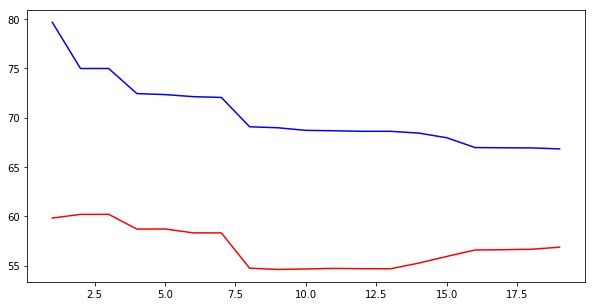

In [66]:
plt.figure(figsize=(10,5))
plt.plot(x,train_er,color='b')
plt.plot(x,test_er,color='r')
plt.show()

可见取前8个特征数较为合适，此时训练集误差达到最小值。

In [67]:
lin = LinearRegression()
lin.fit(weather_sydney[columns[0:8]], weather_sydney['RISK_MM'])
pd.DataFrame(data={'feature':columns[0:8],'coef':lin.coef_})

,feature,coef
0,Humidity3pm,0.152114
1,Sunshine,-0.470213
2,Cloud3pm,0.006298
3,Rainfall,0.160470
4,Cloud9am,-0.131530
5,Humidity9am,0.008717
6,Temp3pm,-0.092645
7,WindGustSpeed,0.152172


In [68]:
y_pred = lin.predict(weather_sydney[columns[0:8]])
r2_score( weather_sydney['RISK_MM'], y_pred)

0.25271663196425176

在此我们得到模型的$R^2$约为0.25。首先观察模型系数，湿度的系数最高，说明湿度上升会增加第二天的降水量。上午9时的云层厚度对第二天的降水量有负作用。然而我们注意到，在这个模型里，相邻两天的降水量会互相影响。

## 逻辑回归

尝试仅预测是否下雨，即分类。这里我们使用逻辑回归。使用前先剔除掉数据集中记录明日降水量的‘RISK_MM’，并将‘RainTomorrow’作为预测对象。

In [72]:
y=weather_sydney['RainTomorrow']
X=weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]
best=SelectKBest(f_classif, k=10)
best.fit(X,y)


SelectKBest(k=10, score_func=<function f_classif at 0x000002CBDADE1400>)

In [73]:
columns=(X.columns[best.get_support(indices=True)])
X=best.transform(X)

In [74]:
weather_sydney['RainTomorrow'].value_counts()

0    1276
1     416
Name: RainTomorrow, dtype: int64

数据类别有些不平衡，明显下雨天的样本过少。因此我们使用交叉验证法对类别权重进行调参。

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

Best parameters : {'class_weight': {0: 0.4289473684210526, 1: 0.5710526315789475}}


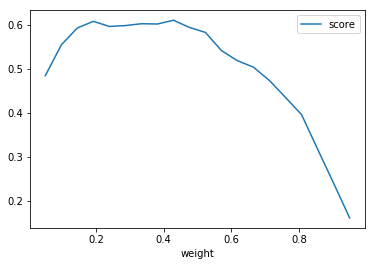

In [99]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[columns[0:9]], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)
    
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [100]:
cv_results=pd.DataFrame(gsc.cv_results_)
cv_results

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\skle

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.005783,0.001076,0.001099,0.000297,"{0: 0.05, 1: 0.95}","{'class_weight': {0: 0.05, 1: 0.95}}",0.482759,0.495413,0.469565,0.490196,...,0.491335,0.494289,0.483871,0.494312,0.489209,0.486322,0.494867,0.494845,0.490322,0.004548
1,0.004687,0.000457,0.001197,0.000399,"{0: 0.09736842105263158, 1: 0.9026315789473685}","{'class_weight': {0: 0.09736842105263158, 1: 0...",0.547368,0.602410,0.551020,0.527473,...,0.557500,0.566751,0.558714,0.559406,0.557908,0.545900,0.562577,0.555831,0.558268,0.005303
2,0.005587,0.000661,0.001196,0.000401,"{0: 0.14473684210526316, 1: 0.8552631578947368}","{'class_weight': {0: 0.14473684210526316, 1: 0...",0.578313,0.666667,0.575000,0.608696,...,0.601156,0.604585,0.597143,0.602026,0.595989,0.596844,0.599713,0.597143,0.599350,0.004668
3,0.005386,0.000799,0.001295,0.000454,"{0: 0.19210526315789472, 1: 0.8078947368421052}","{'class_weight': {0: 0.19210526315789472, 1: 0...",0.589744,0.636364,0.578947,0.603175,...,0.613459,0.611801,0.605016,0.617785,0.606532,0.611367,0.611285,0.607874,0.610388,0.003477
4,0.006194,0.001336,0.001294,0.000633,"{0: 0.23947368421052628, 1: 0.7605263157894737}","{'class_weight': {0: 0.23947368421052628, 1: 0...",0.520548,0.612903,0.553846,0.612903,...,0.614094,0.605042,0.600671,0.611018,0.614601,0.606260,0.606061,0.608108,0.608875,0.005256
5,0.004796,0.000755,0.000894,0.000828,"{0: 0.28684210526315784, 1: 0.7131578947368422}","{'class_weight': {0: 0.28684210526315784, 1: 0...",0.529412,0.620690,0.524590,0.633333,...,0.608696,0.597826,0.592727,0.602151,0.603636,0.601073,0.600362,0.618445,0.603794,0.007822
6,0.004684,0.000636,0.000701,0.000459,"{0: 0.33421052631578946, 1: 0.6657894736842105}","{'class_weight': {0: 0.33421052631578946, 1: 0...",0.548387,0.555556,0.535714,0.607143,...,0.613861,0.606299,0.585657,0.607495,0.607004,0.594912,0.604743,0.612967,0.603261,0.008658
7,0.005086,0.001044,0.000796,0.000398,"{0: 0.381578947368421, 1: 0.618421052631579}","{'class_weight': {0: 0.381578947368421, 1: 0.6...",0.517241,0.576923,0.549020,0.615385,...,0.616977,0.613108,0.594480,0.612766,0.608333,0.597077,0.611111,0.622129,0.611066,0.008513
8,0.004588,0.000490,0.000696,0.000456,"{0: 0.4289473684210526, 1: 0.5710526315789475}","{'class_weight': {0: 0.4289473684210526, 1: 0....",0.538462,0.553191,0.553191,0.640000,...,0.619469,0.605791,0.593258,0.585586,0.613687,0.599553,0.610245,0.622807,0.609543,0.012593
9,0.004684,0.000995,0.000995,0.000446,"{0: 0.47631578947368414, 1: 0.5236842105263159}","{'class_weight': {0: 0.47631578947368414, 1: 0...",0.520000,0.565217,0.521739,0.625000,...,0.613272,0.586605,0.582751,0.586605,0.601852,0.593607,0.597222,0.605081,0.597249,0.010276


In [101]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
logmean=gsc.cv_results_['mean_test_score'][index]
logstd=gsc.cv_results_['std_test_score'][index]
log_score=cv_results.loc[4,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [102]:
index

(array([8], dtype=int64),)

In [103]:
print('mean_score:',logmean)
print('std_score:',logstd)

mean_score: [0.60991999]
std_score: [0.07473844]


In [104]:
gsc.best_estimator_

LogisticRegression(C=1.0,
          class_weight={0: 0.4289473684210526, 1: 0.5710526315789475},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

In [105]:
gsc.best_score_

0.6099199865409604

在权重为0.2时模型得分最高。f1值约为0.63。

In [108]:
y_pre=LogisticRegression(class_weight={0: 0.2, 1: 0.8}).fit(X_train,y_train).predict(X_test)
f1_score(y_test,y_pre)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6269430051813472

训练得到的模型在测试集上的F1为0.62

## 决策树

In [82]:
weather_sydney2.columns.difference(['RainToday','RainTomorrow','RISK_MM'])

Index(['Cloud3pm', 'Cloud9am', 'Evaporation', 'Humidity3pm', 'Humidity9am',
       'MaxTemp', 'MinTemp', 'Pressure3pm', 'Pressure9am', 'Rainfall',
       'Sunshine', 'Temp3pm', 'Temp9am', 'WindDir3pm', 'WindDir9am',
       'WindGustDir', 'WindGustSpeed', 'WindSpeed3pm', 'WindSpeed9am'],
      dtype='object')

In [112]:
from sklearn.tree import DecisionTreeClassifier

In [113]:
weather_sydney2[weather_sydney2.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]

,Cloud3pm,Cloud9am,Evaporation,Humidity3pm,Humidity9am,MaxTemp,MinTemp,Pressure3pm,Pressure9am,Rainfall,Sunshine,Temp3pm,Temp9am,WindDir3pm,WindDir9am,WindGustDir,WindGustSpeed,WindSpeed3pm,WindSpeed9am
30487,1.0,3.0,3.0,57.0,70.0,20.3,12.9,1025.6,1028.8,0.2,10.9,19.8,16.9,E,W,ENE,37.0,26.0,11.0
30488,5.0,2.0,6.6,58.0,75.0,21.5,13.3,1022.4,1025.9,0.0,11.0,21.3,17.6,ENE,W,ENE,41.0,28.0,11.0
30489,4.0,1.0,5.6,63.0,70.0,23.0,15.3,1017.8,1021.4,0.0,11.0,22.2,19.0,ENE,W,NNE,41.0,19.0,6.0
30493,5.0,1.0,3.8,56.0,73.0,26.7,12.9,1015.0,1018.0,0.2,12.1,22.5,17.8,ENE,W,NE,33.0,24.0,13.0
30494,7.0,2.0,6.8,69.0,76.0,23.8,14.8,1014.7,1016.0,0.0,9.6,20.6,20.2,SE,SSE,SSE,54.0,26.0,13.0
30496,7.0,7.0,6.2,59.0,82.0,22.1,14.5,1017.5,1020.7,0.2,1.8,20.5,16.2,ENE,WNW,ENE,31.0,15.0,11.0
30499,8.0,8.0,6.6,77.0,78.0,20.4,18.1,1012.1,1014.7,5.2,0.1,18.6,18.7,SSE,S,SSE,48.0,28.0,22.0
30501,3.0,1.0,4.0,54.0,65.0,23.9,12.0,1016.3,1018.1,0.2,11.9,20.7,17.6,ESE,W,SE,44.0,24.0,13.0
30502,7.0,7.0,5.4,68.0,83.0,18.1,14.4,1020.5,1022.3,0.4,2.8,17.6,14.8,SE,S,ESE,48.0,20.0,15.0
30503,7.0,7.0,8.4,53.0,67.0,19.2,13.4,1022.1,1023.9,8.4,2.7,17.8,15.2,SSE,SE,SE,46.0,30.0,17.0


In [114]:
X_test

,Cloud3pm,Cloud9am,Evaporation,Humidity3pm,Humidity9am,MaxTemp,MinTemp,Pressure3pm,Pressure9am,Rainfall,Sunshine,Temp3pm,Temp9am,WindDir3pm,WindDir9am,WindGustDir,WindGustSpeed,WindSpeed3pm,WindSpeed9am
32076,7.0,7.0,2.4,52.0,84.0,18.3,11.1,1017.8,1022.0,0.2,1.1,17.0,13.1,WNW,WNW,W,28.0,9.0,11.0
32778,5.0,5.0,4.0,40.0,78.0,25.6,13.2,1014.9,1019.5,0.0,9.5,24.2,15.9,N,W,NNW,30.0,19.0,11.0
32326,7.0,8.0,7.6,55.0,87.0,24.8,19.1,1012.8,1012.0,10.8,0.8,23.5,19.7,S,SSW,S,59.0,33.0,24.0
32274,3.0,3.0,8.0,59.0,63.0,29.6,18.3,1013.4,1015.4,0.0,13.1,25.5,23.4,E,WNW,ENE,28.0,19.0,9.0
32496,1.0,1.0,7.6,31.0,35.0,17.4,14.5,1003.8,1004.3,6.0,10.0,17.0,14.5,W,WNW,WNW,69.0,43.0,44.0
31122,2.0,1.0,2.0,43.0,47.0,20.6,11.7,1010.7,1014.7,0.0,9.2,17.4,13.5,E,W,W,35.0,19.0,26.0
32289,1.0,6.0,7.4,38.0,51.0,24.9,15.4,1020.7,1022.4,0.2,12.5,24.1,21.2,ESE,SE,SSE,35.0,22.0,20.0
32758,7.0,7.0,3.6,48.0,56.0,23.0,13.8,1017.3,1017.2,0.0,2.1,22.2,17.9,SSW,W,SSW,54.0,26.0,22.0
32182,1.0,1.0,3.8,60.0,61.0,22.3,12.4,1025.0,1028.5,0.0,10.6,21.4,18.3,E,WNW,NNE,30.0,20.0,11.0
31109,1.0,7.0,3.6,32.0,58.0,18.5,6.8,1014.4,1017.8,0.0,7.7,18.1,9.7,NW,W,WNW,31.0,11.0,9.0


Best parameters : {'max_depth': 8}


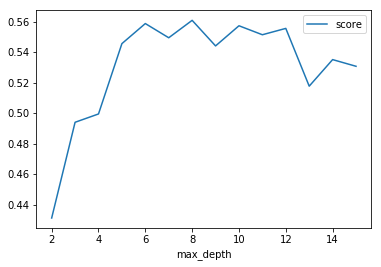

In [130]:
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)

gsc = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)


dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15] })
dataz.plot(x='max_depth')

可见‘max_depth’取7时较为合适。

In [122]:
cv_results=pd.DataFrame(gsc.cv_results_)


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\skle

In [123]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
frmean=gsc.cv_results_['mean_test_score'][index]
frstd=gsc.cv_results_['std_test_score'][index]
fr_score=cv_results.loc[3,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [124]:
print('mean_score:',frmean)
print('std_score:',frstd)

mean_score: [0.5714881]
std_score: [0.09567225]


In [132]:
dtree=DecisionTreeClassifier(max_depth=7)
dtree.fit(X_train,y_train)
f1_score(dtree.predict(X_test),y_test)

#f1_score(y_test,y_pre)

0.5736434108527132

## 假设检验

从结果上看似乎逻辑回归模型f1值更高，记逻辑回归的f1值为$F1_log$,决策树模型的f1值为$F1_fr$。现在我们提出如下假设：
$H_0:F1_{log}=F1_{fr}$
$H_1:F1_{log}>F1_{fr}$

In [44]:
from scipy import stats


In [45]:
stats.mstats.ttest_ind(log_score,fr_score).pvalue<0.5

True

拒绝原假设，可认为逻辑回归的f1值高于决策树模型。